In [ ]:
# default_exp graph

In [94]:
#export
from wong.imports import *

# Graph
> Generate DAG graphs that abstract architectures of CNNs

Suppose the generated DAG has $n$ nodes, then the identity of nodes is from $0$ to $n-1$.

## ResNets
>The DAG graphs of ResNets.


In [95]:
from fastdot import *

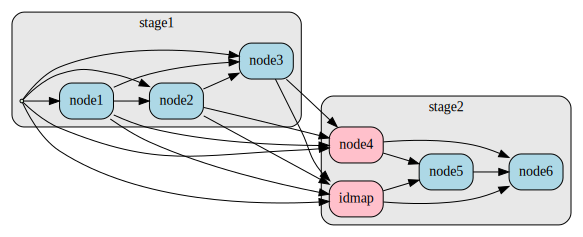

In [96]:
stage1 = Cluster('stage1')
start = stage1.add_item(Point())
node1 = stage1.add_item('node1', fillcolor='lightblue')
node2 = stage1.add_item('node2', fillcolor='lightblue')
node3 = stage1.add_item('node3', fillcolor='lightblue')
stage1.add_items(start.connect(node1),start.connect(node2),start.connect(node3),
                 node1.connect(node2),node1.connect(node3),
                 node2.connect(node3),
                )

stage2 = Cluster('stage2')
node4 = stage2.add_item('node4', fillcolor='pink')
node5 = stage2.add_item('node5', fillcolor='lightblue')
node6 = stage2.add_item('node6', fillcolor='lightblue')
idmap = stage2.add_item('idmap', fillcolor='pink')
stage2.add_items(start.connect(node4),node1.connect(node4),node2.connect(node4),node3.connect(node4),
                 start.connect(idmap),node1.connect(idmap),node2.connect(idmap),node3.connect(idmap),
                 node4.connect(node5),node4.connect(node6),idmap.connect(node5),idmap.connect(node6),
                 node5.connect(node6),
                )
#stage1.add_items(node1.connect(idmap), node2.connect(idmap))

g = Dot()
g.add_item(stage1)
g.add_item(stage2)
g

In [ ]:
#export
def complete_dag(n:int):
    "Generate a complete directed acyclic graph, which corresponds to architecture of ResNet."
    G = nx.DiGraph()
    nodes = list(range(n))
    for id in nodes:
        for succ in range(id+1, n):
            G.add_edge(id, succ)    
    return G

In [109]:
# Constraint: the number of stages MUST BE 4!
num_nodes = (3,4,6,3)
num_stages = len(num_nodes)
num_all_nodes = sum(num_nodes) + 1 + 1 + (num_stages-1)
G = nx.DiGraph()
for i in range(num_all_nodes):
    if i < 1 + num_nodes[0]: # nodes of first stage
        G.add_node(i, stage = 0, optype = 'resnet_bottleneck')
        for succ in range(i+1, 1 + num_nodes[0] + 1 + 1):
            G.add_edge(i, succ)
    elif i < 1 + num_nodes[0] + num_nodes[1] + 1: # nodes of second stage
        if i == 1 + num_nodes[0]:
            G.add_node(i, stage = 0, optype = 'idmap')
        else:
            G.add_node(i, stage = 0, optype = 'resnet_bottleneck')
        

In [111]:
G.nodes.data(), G.edges

(NodeDataView({0: {'stage': 0}, 1: {'stage': 0}, 2: {'stage': 0}, 3: {'stage': 0}, 4: {}, 5: {}}),
 OutEdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)]))

In [ ]:
#export
def resnet_dag(num_nodes:tuple):
    "Generate the DAG corresponding to the architecture of ResNet. Input is numbers of nodes of all stages."
    num_stages = len(num_nodes)
    G = nx.DiGraph()
    # an unique input node which connected to all nodes of the first stage, 
    # and the two nodes that accross first stage and secton stage
    
    # an unique output node with connected to all nodes of the last stage

The DAG only have one type of nodes, the operation node. We could add a new type of node, the aggregate node, or memory node, that will cache the previous data in order to be used by following operation nodes. In order to generate such memory nodes, we need traverse the DAG from behind to start.

Suppose the DAG have $n$ nodes, then:
1. Choose the last node $n-1$ as the current node, the second last node $n-2$ as the previous node.
2. Compare the sets of input nodes of the current node and the previous node, the intersection of two sets are the nodes that input to both the current node and the previous node, the complement set A are the nodes that input into the current node but not into the previous node,
3. A new memory node is inserted to graph. rewiring the intersection to the new memory node, and let the new node connected to both the previous node and the current node.
4. 